# 1. Primary Key
---

## 1.1. Index

Indexes are used to find rows with specific column values quickly. Without an index, MySQL must begin with the first row and then read through the entire table to find the relevant rows. The larger the table, the more this costs. If the table has an index for the columns in question, MySQL can quickly determine the position to seek to in the middle of the data file without having to look at all the data. This is much faster than reading every row sequentially.

Any column in creating table statement declared as `PRIMARY KEY`, `KEY`, `UNIQUE`or `INDEX` will be indexed automatically by MySQL. Most MySQL indexes (PRIMARY KEY, UNIQUE, INDEX, and FULLTEXT) are stored in [B-trees](https://dev.mysql.com/doc/refman/8.0/en/glossary.html#glos_b_tree). 

- [MySQL 8.0 Reference Manual :: 8.3.1 How MySQL Uses Indexes](https://dev.mysql.com/doc/refman/8.0/en/mysql-indexes.html)

- [The Benefits of Indexing Large MySQL Tables](https://www.drupal.org/docs/7/guidelines-for-sql/the-benefits-of-indexing-large-mysql-tables) 需要取消ad blocker才能访问

## 1.2. Clustered and Secondary Indexes

Each InnoDB table has a special index called the clustered index that stores row data. Typically, the clustered index is synonymous with the primary key. To get the best performance from queries, inserts, and other database operations, it is important to understand how InnoDB uses the clustered index to optimize the common lookup and DML operations.

1. When you define a `PRIMARY KEY` on a table, **InnoDB** uses it as the **clustered index**. **A primary key should be defined for each table**. If there is no logical unique and non-null column or set of columns to use a the primary key, add an auto-increment column. Auto-increment column values are unique and are added automatically as new rows are inserted.

2. If you do not define a `PRIMARY KEY` for a table, **InnoDB** uses the first `UNIQUE index` with all key columns defined as NOT NULL as the clustered index.

3. If a table has no `PRIMARY KEY` or suitable `UNIQUE index`, InnoDB generates a hidden clustered index named `GEN_CLUST_INDEX` on a synthetic column that contains row ID values. The rows are ordered by the row ID that InnoDB assigns. The row ID is a 6-byte field that increases monotonically as new rows are inserted. Thus, the rows ordered by the row ID are physically in order of insertion.

从以上可以看出, Clustered Indexe就是你用pk修饰的那一列, 比如ID, 然后创建表的时候就应该设置PK在使用MySQL的时候, 然后这些PK(唯一标识行)以B-Tree的结构被InnoDB Engine组织用于快速查找而不是笨笨的一行一行的遍历. 如果你不声明PK或者Unique的列, 那InnoDB只好自动帮你创建一个PK(implicitly, hidden form you).

- [MySQL 8.0 Reference Manual :: 15.6.2.1 Clustered and Secondary Indexes](https://dev.mysql.com/doc/refman/8.0/en/innodb-index-types.html)

## 1.3. Should Each Table Have a Primary Key?

Short answer: yes, each table should have a PRIMARY KEY so that you could distinguish two records. 

In MySQL, the **InnoDB storage engine** always creates a primary key if you didn't specify it explicitly, thus making an extra column you don't have access to.


其实不用多说了, 通过上面的讨论已经知道, 答案是肯定的. 

# 2. 数据库如何存储时间
---

### 2.1. 不要用字符串存储日期

- 字符串占用的空间更大
- 字符串存储的日期比较效率比较低（逐个字符进行比对），无法用日期相关的 API 进行计算和比较

### 2.2. Datetime 和 Timestamp 的选择

`Datetime` 和 `Timestamp` 是 MySQL 提供的两种比较相似的保存时间的数据类型, 通常我们都会首选 `Timestamp`. 因为DateTime类型没有时区信息的, 而Timestamp可以存储time zone信息, 并且做转换. 

Timestamp 只需要使用 4 个字节的存储空间，但是 DateTime 需要耗费 8 个字节的存储空间。但是，这样同样造成了一个问题，Timestamp 表示的时间范围更小。

- DateTime ：1000-01-01 00:00:00 ~ 9999-12-31 23:59:59
- Timestamp： 1970-01-01 00:00:01 ~ 2037-12-31 23:59:59

```sql
CREATE TABLE `time_zone_test` (
  `id` int NOT NULL AUTO_INCREMENT,
  `date_time` datetime DEFAULT NULL,
  `time_stamp` timestamp NOT NULL DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP,
  PRIMARY KEY (`id`)
);


INSERT INTO time_zone_test(date_time) VALUES(NOW());

select * from time_zone_test;

+----+---------------------+---------------------+
| id | date_time           | time_stamp          |
+----+---------------------+---------------------+
|  1 | 2023-04-01 10:45:04 | 2023-04-01 10:45:04 |
+----+---------------------+---------------------+
```

这也说明了一个问题, 就是我们插入数据的时候, 没必要在逻辑上获取时间再加入, 我们只需要在创建表的时候设置一个time column并为其设置default值, 即可, 每次只用在Java代码中插入其他column, 然后时间会被mysql自动加上去. 

对于上面的数据, 我们修改会话的时区, 可以看到时间就变了:

```sql
set time_zone='+8:00';

+----+---------------------+---------------------+
| id | date_time           | time_stamp          |
+----+---------------------+---------------------+
|  1 | 2023-04-01 10:45:04 | 2023-04-01 21:45:04 |
+----+---------------------+---------------------+
```

- [老生常谈！数据库如何存储时间？你真的知道吗？ - 掘金](https://juejin.cn/post/6844904047489581063)

# 3. 查看MySQL Warning
---- 

有时候我们创建表的时候或者执行SQL语句, 虽然执行成功了但是会显示有警告,但是还不告诉你警告内容, 这时候你需要立刻执行`SHOW WARNINGS;`语句, 否则你执行了其他语句再执行这个show, 那现实的就不是上一个语句的warnings了, 如下图:


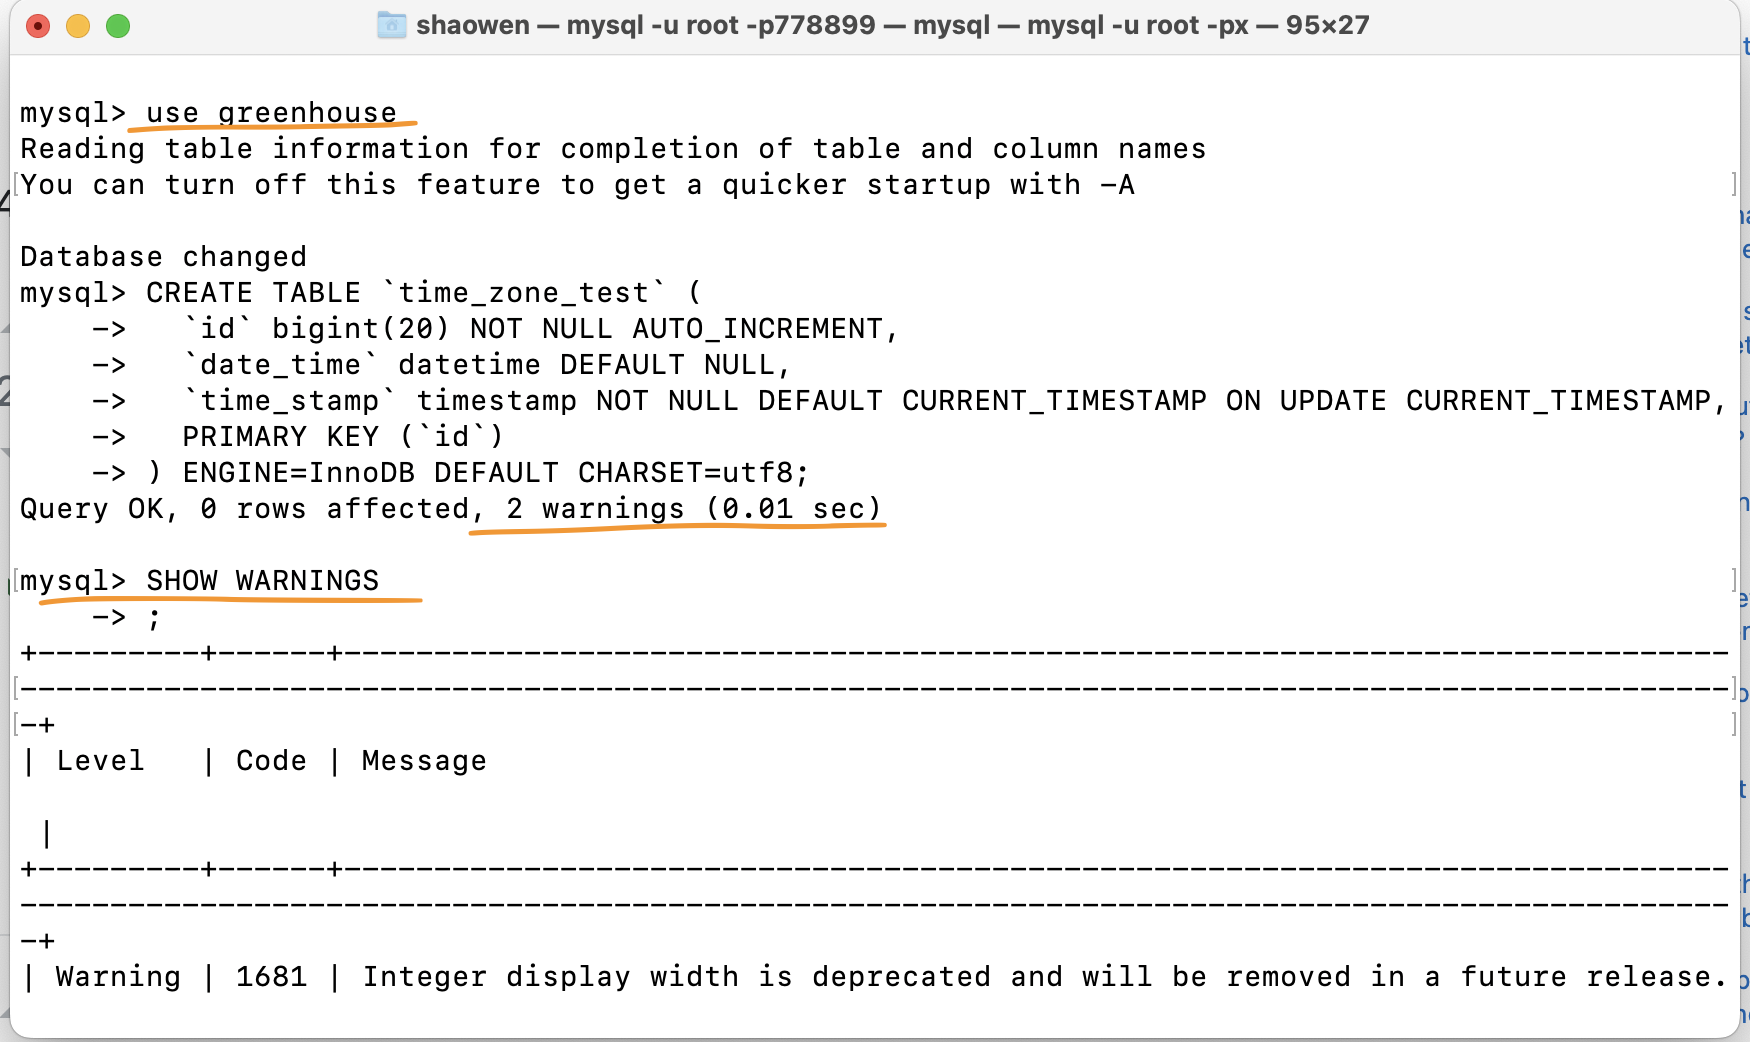

# 4. Default vs NOT NULL 
----

有没有想过, 建表的时候default 和 not null一起使用, 是不是有点redundant? 因为比如你不插入值的时候mysql会帮你插入默认值, 

其实这么想你就错了, 你想的是我不插入, mysql就会帮我插入个默认值, 所以似乎not null没起作用, 但是你有没有想过如果你只设置了default而没有设置not null限制, 那这时候我插入null个呢, 显然可以插入成功, 但有时候为null, 比如一个日期, 当我们在写Java或者其他代码的时候查询数据然后把date转为string, 如果数据为null可能就会发生异常~

所以not null主要的作用是是你不能插入null, 

# 5. 建表语句
----

```sql
CREATE TABLE `humidity` (
  `id` int NOT NULL AUTO_INCREMENT,
  `value` float NOT NULL,
  `created_date` timestamp NOT NULL DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP,
  PRIMARY KEY (`id`)
);
```